# Grid convergence for the NF3 molecule

This notebook aims at finding the coarsest and smallest grid possible
to let the precision per atom be under 2.0e-03 eV for the NF3
molecule.

First, the convergence of the coarse and fine grids extension will
be considered, then so will be the convergence of the grid spacing.
Both parameters will be converged up to 1.0e-03 eV, leading to
the above-mentioned total precision of 2.0e-03 eV.

## Initalization

Let us first import all the useful tools allowing us to find the
converged grid parameters for the BigDFT code.

In [1]:
import matplotlib.pyplot as plt
from mybigdft import InputParams, Posinp, Atom, Job
from mybigdft.workflows import HgridsConvergence, RmultConvergence
from mybigdft.globals import DEFAULT_PARAMETERS, EV_TO_HA
savefig = False

## Define a base job

We must start by defining a base job to be able to consider the convergence
with respect to rmult for this molecule. The base job uses some base input
parameters and the initial positions given a in a file.

In [2]:
name = "NF3"
pos = Posinp.from_file("NF3.xyz")
inp = InputParams({'dft': {'hgrids': 0.3}})
base_job = Job(posinp=pos, inputparams=inp, name=name,
               run_dir="NF3/rmc/hg_0.30")

## Grid extension convergence

The reference rmult is [11, 14], and it will be decreased by
[-0.5, -0.5] for each job of the workflow until the precision per atom of the
given job with respect to the reference job is above 1.e-3 eV. There will be a
maximum of 14 jobs.

In [3]:
rmc = RmultConvergence(base_job, reference=[11, 14], delta=[-0.5, -0.5],
                       n_jobs=14, precision_per_atom=1.e-3*EV_TO_HA)

In [4]:
rmc.run(nmpi=1, nomp=3)

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/11.0_14.0
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/10.5_13.5
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/10.0_13.0
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/9.5_12.5
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/9.0_12.0
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/8.5_11.5
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/8.0_11.0
Logfile log-NF3.yaml already exist

/Users/maximemoriniere/Documents/Python/MyBigDFT/mybigdft/workflows/convergences.py:332: UserWarning: The job with minimal energy does not correspond to the job with maximal rmult. Consider decreasing hgrids or the reference rmult.
  warnings.warn(self._too_low_energy_msg, UserWarning)


/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/7.0_10.0
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/6.5_9.5
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/rmc/hg_0.30/6.0_9.0
Logfile log-NF3.yaml already exists!



/Users/maximemoriniere/Documents/Python/MyBigDFT/mybigdft/workflows/workflow.py:121: UserWarning: Some jobs of the workflow were not run.
  UserWarning)


In [5]:
rmc.summary()

Requested precision per atom: 3.67e-05 (Ha)
-----------------------------------------------------
    rmult      precision_per_atom (Ha)  is_converged 
-----------------------------------------------------
 [11.0, 14.0]          0.00e+00             True     
 [10.5, 13.5]          1.99e-09             True     
 [10.0, 13.0]          1.35e-08             True     
 [9.5, 12.5]           3.85e-08             True     
 [9.0, 12.0]           8.59e-08             True     
 [8.5, 11.5]           2.55e-07             True     
 [8.0, 11.0]          -3.83e-06             True     
 [7.5, 10.5]           3.50e-06             True     
 [7.0, 10.0]           3.00e-07             True     
  [6.5, 9.5]           1.86e-05             True     
  [6.0, 9.0]           4.40e-05            False     


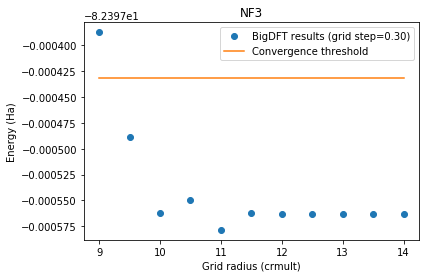

In [6]:
energies = [job.logfile.energy for job in rmc.queue if job.is_completed]
rmults = [job.param for job in rmc.queue if job.is_completed]
crmult = [rmult[1] for rmult in rmults]
n_at = len(rmc.queue[0].posinp)
threshold = min(energies) + n_at*rmc.precision_per_atom
hg = inp["dft"]["hgrids"]

fig=plt.figure()
fig.patch.set_facecolor('white')  # When dark background
plt.plot(crmult, energies, label=f"BigDFT results (grid step={hg:.2f})", marker="o", linestyle='')
plt.plot(crmult, [threshold]*len(energies), label="Convergence threshold")
plt.title(name)
plt.xlabel("Grid radius (crmult)")
plt.ylabel("Energy (Ha)")
plt.legend()
if savefig:
    plt.savefig(
        "../MarchMeetingPresentation/Figures/convergence_rmult.png",
        bbox_inches="tight",
    )
plt.show()

## Define a new base job

In [7]:
# Get the input parameters of the converged job
new_inp = rmc.converged.inputparams
# Get the value of the converged rmult
rmult = rmc.converged.param
new_base_job = Job(posinp=pos, inputparams=new_inp, name=name,
                   run_dir="NF3/hgc/{}_{}".format(*rmult))

## Grid-step convergence

The reference hgrids is 0.16, and it will be increased by
0.02 for each job of the workflow until the precision per atom of the
given job with respect to the reference job is above 1.e-3 eV. There will be a
maximum of 16 jobs.

In [8]:
hgc = HgridsConvergence(new_base_job, reference=0.16, delta=0.02,
                        n_jobs=16, precision_per_atom=1.e-3*EV_TO_HA)

In [9]:
hgc.run(nmpi=1, nomp=3)

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/hgc/6.5_9.5/0.16_0.16_0.16
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/hgc/6.5_9.5/0.18_0.18_0.18
Logfile log-NF3.yaml already exists!

/Users/maximemoriniere/Documents/calculs/MyBigDFT/automatic/convergence_studies/NF3/hgc/6.5_9.5/0.20_0.20_0.20
Logfile log-NF3.yaml already exists!



/Users/maximemoriniere/Documents/Python/MyBigDFT/mybigdft/workflows/workflow.py:121: UserWarning: Some jobs of the workflow were not run.
  UserWarning)


In [10]:
hgc.summary()

Requested precision per atom: 3.67e-05 (Ha)
-----------------------------------------------------------
       hgrids        precision_per_atom (Ha)  is_converged 
-----------------------------------------------------------
 [0.16, 0.16, 0.16]          0.00e+00             True     
 [0.18, 0.18, 0.18]          7.14e-06             True     
 [0.20, 0.20, 0.20]          3.88e-05            False     


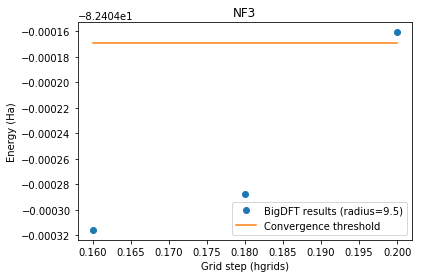

In [11]:
energies = [job.logfile.energy for job in hgc.queue if job.is_completed]
hgrids = [job.param for job in hgc.queue if job.is_completed]
hgrids_x = [hgrid[0] for hgrid in hgrids]
n_at = len(rmc.queue[0].posinp)
threshold = min(energies) + n_at*hgc.precision_per_atom
try:
    crm = new_inp["dft"]["rmult"][1]
except KeyError:
    crm = DEFAULT_PARAMETERS["dft"]["rmult"][1]

fig=plt.figure()
fig.patch.set_facecolor('white')  # When dark background
plt.plot(hgrids_x, energies, label=f"BigDFT results (radius={crm:.1f})", marker="o", linestyle='')
plt.plot(hgrids_x, [threshold]*len(energies), label="Convergence threshold")
plt.title(name)
plt.xlabel("Grid step (hgrids)")
plt.ylabel("Energy (Ha)")
plt.legend()
if savefig:
    plt.savefig(
        "../MarchMeetingPresentation/Figures/convergence_hgrids.png",
        bbox_inches="tight",
    )
plt.show()
plt.show()

## Conclusion

The converged grid parameters for the NF3 molecule, given a precision
per atom of at least 2.0e-03 eV are given below:

In [12]:
hgc.converged.inputparams

{'dft': {'hgrids': [0.18, 0.18, 0.18], 'rmult': [6.5, 9.5]}}